## ML Models


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree

%run ../model_preparation/import_model_data.ipynb
%store -r model_df

model_df['Year'] = model_df['time'].dt.year
model_df['Month'] = model_df['time'].dt.month
model_df['Day'] = model_df['time'].dt.day
model_df['Hour'] = model_df['time'].dt.hour

model_df.drop('time', axis=1, inplace=True)

# Umwandlung kategorialer Variablen in Dummy-Variablen
model_df = pd.get_dummies(model_df, columns=['Weekday', 'weather_description'])

model_df['siteIDIsOne'] = model_df['siteID'] == '1'
model_df.drop('siteID', axis=1, inplace=True)

# Zielvariable und Merkmale trennen
X = model_df.drop('occupied_count', axis=1)  # Merkmale
y = model_df['occupied_count']               # Zielvariable

# Aufteilen in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Stored 'model_df' (DataFrame)


### Linear regression


In [12]:
pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('lin_reg', LinearRegression())
])

# Einstellen der Parameter für die Kreuzvalidierung
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Durchführen der Kreuzvalidierung
scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

print(f"Durchschnittlicher Mean Squared Error während Kreuzvalidierung: {np.mean(-scores)}")


# Trainieren des Modells mit allen Trainingsdaten
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error: {test_mse}")

Durchschnittlicher Mean Squared Error während Kreuzvalidierung: 129.06939425013383
Test Mean Squared Error: 126.79444817490875


### Polynomial regression


In [13]:

# Definieren der Pipeline
# Nachdem ich viele verschiedene Parameter versucht habe, habe ich mit diesen das beste Ergebnis erreicht
# Eine Kreuzvalidierung mittels beispielsweise GridSearchCV dauert zu lange
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=4)),
    ('scaling', StandardScaler()),
    ('ridge', Ridge(alpha=0.01))
])

# Training des Modells auf den Trainingsdaten
pipeline.fit(X_train, y_train)

# Vorhersage auf den Testdaten
y_pred = pipeline.predict(X_test)

# Berechnung des Mean Squared Error (MSE) auf den Testdaten
test_mse = mean_squared_error(y_test, y_pred)

print("Test MSE:", test_mse)

Test MSE: 75.25571557077296


### Decision Tree


Stored 'model_df' (DataFrame)


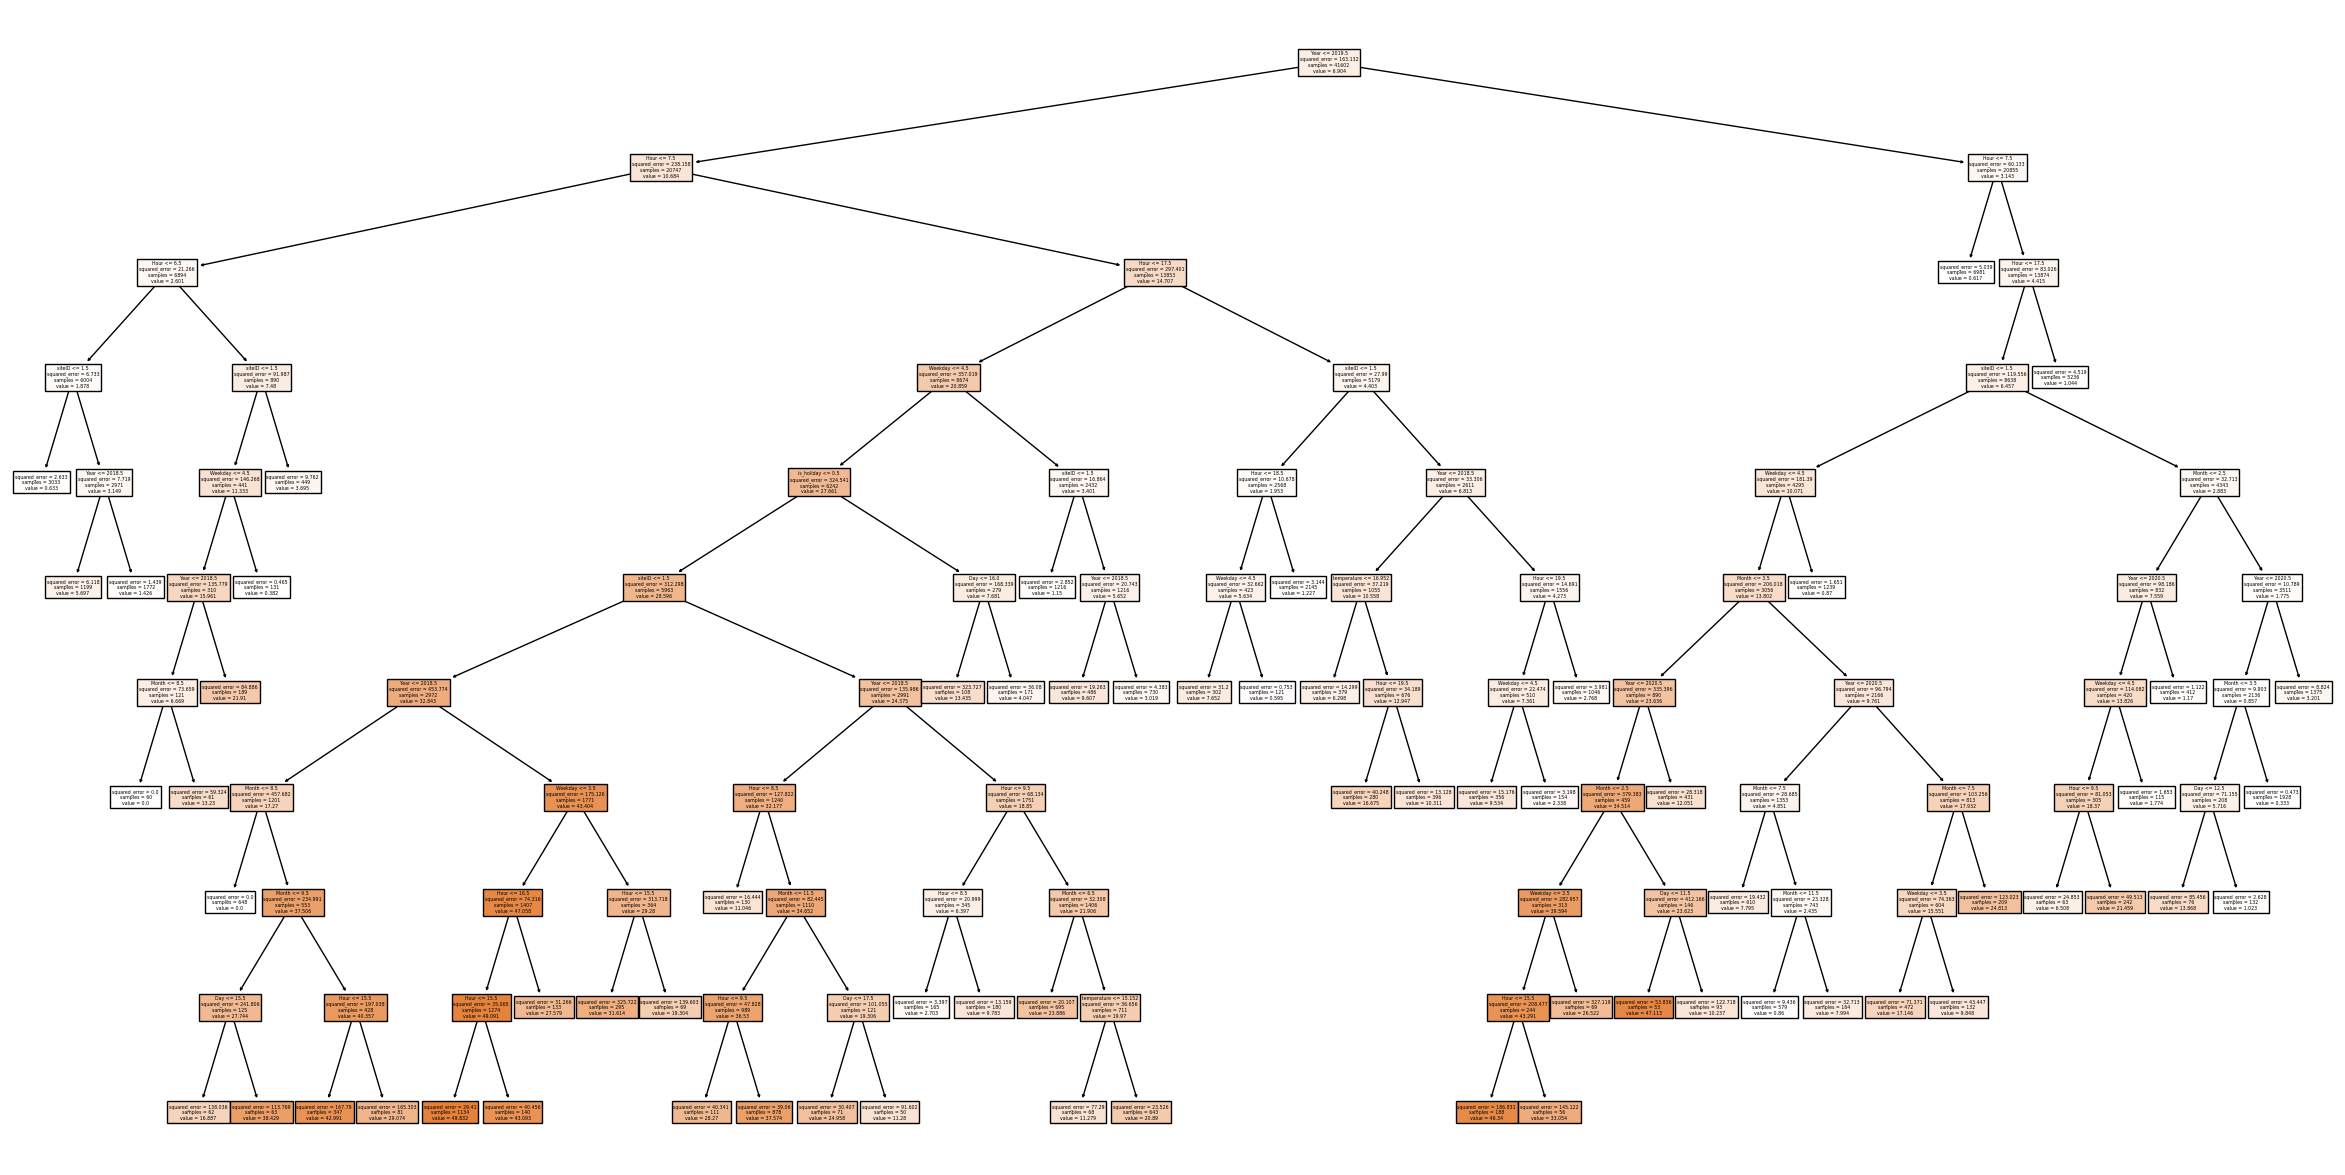

Beste Parameter: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 50}
Test MSE: 17.966559934618147


In [11]:
%run ../model_preparation/import_model_data.ipynb
%store -r model_df

# Aufteilen der 'time'-Spalte in Jahr, Monat, Tag und Stunde
model_df['Year'] = model_df['time'].dt.year
model_df['Month'] = model_df['time'].dt.month
model_df['Day'] = model_df['time'].dt.day
model_df['Hour'] = model_df['time'].dt.hour
model_df.drop('time', axis=1, inplace=True)

# Ich halte mögliche Vergleiche wie Weekday >= 5 sinnvoll, um Wochentag und Wochenende unterscheiden zu können
weekday_map = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
model_df['Weekday'] = model_df['Weekday'].map(weekday_map)

# Umwandlung kategorialer Variablen in Dummy-Variablen
model_df = pd.get_dummies(model_df, columns=['weather_description'])

# Zielvariable und Merkmale trennen
X = model_df.drop('occupied_count', axis=1)
y = model_df['occupied_count']

# Aufteilen in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Parameter für GridSearchCV
param_grid = {
    'max_depth': [5, 7, 10],
    'min_samples_leaf': [50, 100, 500, 1000, 1500],
    'max_features': ['sqrt', 'log2', None]
}

# GridSearchCV auf den Trainingsdaten
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42, ccp_alpha=0.1), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Beste Parameter und Modell
best_params = grid_search.best_params_
best_tree = grid_search.best_estimator_

plt.figure(figsize=(30, 15))
plot_tree(best_tree, feature_names=X.columns, filled=True)
plt.savefig('../../decision_tree.svg', format='svg')
plt.show()
plt.close() 

# Bewertung auf den Testdaten
y_pred = best_tree.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)

print("Beste Parameter:", best_params)
print("Test MSE:", test_mse)